In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scvi
import scanpy as sc
import csv
from sklearn.manifold import TSNE

# scVI differential genes

In [2]:
adata = scvi.data.cortex() #built in dataset, AnnData as in scanPy

INFO     File /Users/ksenia/Documents/Year20/Fall/scrnaseq_seminar/demo/data/expression.bin  
         already downloaded                                                                  
INFO     Loading Cortex data from                                                            
         /Users/ksenia/Documents/Year20/Fall/scrnaseq_seminar/demo/data/expression.bin       
INFO     Finished loading Cortex data                                                        
INFO     No batch_key inputted, assuming all cells are same batch                            


/Users/ksenia/Documents/!Summer2019/DeepSea_Disease/deepsea-disease/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


INFO     Using labels from adata.obs["labels"]                                               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              


/Users/ksenia/Documents/!Summer2019/DeepSea_Disease/deepsea-disease/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


INFO     Successfully registered anndata object containing 3005 cells, 19972 vars, 1 batches,
         7 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [3]:
adata

AnnData object with n_obs × n_vars = 3005 × 19972
    obs: 'labels', 'precise_labels', 'cell_type', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var'
    uns: '_scvi'

In [4]:
sc.pp.filter_genes(adata, min_counts=3) #scanpy for data preparation

In [5]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [6]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)

/Users/ksenia/Documents/!Summer2019/DeepSea_Disease/deepsea-disease/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


In [7]:
scvi.data.setup_anndata(adata, layer="counts")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 3005 cells, 2000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/Users/ksenia/Documents/!Summer2019/DeepSea_Disease/deepsea-disease/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [8]:
model = scvi.model.SCVI(adata)

In [9]:
model.train()

INFO     Training for 400 epochs                                                             
INFO     KL warmup for 400 epochs                                                            
Training...: 100%|██████████| 400/400 [06:03<00:00,  1.10it/s]
INFO     Training time:  363 s. / 400 epochs                                                 


In [10]:
adata.obs.cell_type.head()

0    interneurons
1    interneurons
2    interneurons
3    interneurons
4    interneurons
Name: cell_type, dtype: object

In [13]:
adata.obs.cell_type = adata.obs.cell_type.astype('category')

In [14]:
de_df = model.differential_expression(
    groupby="cell_type",
    group1="oligodendrocytes",
    group2="pyramidal CA1"
)
de_df.head()

DE...: 100%|██████████| 1/1 [00:03<00:00,  3.00s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison
Ptk2b,1.0000,0.0000,18.420681,0.000371,0.004361,-3.662205,-3.753839,1.001203,-6.919620,1.261342,0.275610,9.059638,0.131707,0.970181,1.270991,54.318600,True,oligodendrocytes vs pyramidal CA1
Tspan13,1.0000,0.0000,18.420681,0.000448,0.010310,-4.782289,-4.919433,1.072857,-7.363059,-0.296619,0.531707,22.612354,0.193902,0.996805,2.175642,138.721069,True,oligodendrocytes vs pyramidal CA1
Itpka,0.9998,0.0002,8.516943,0.000075,0.003136,-6.147781,-6.318114,1.643800,-11.492802,0.709152,0.087805,6.315229,0.062195,0.941427,0.443771,39.066898,True,oligodendrocytes vs pyramidal CA1
Slc8a1,0.9998,0.0002,8.516943,0.000616,0.009515,-4.151778,-4.283736,1.009087,-6.985088,-0.243304,1.060976,20.086262,0.352439,0.991480,4.516073,115.609520,True,oligodendrocytes vs pyramidal CA1
Aire,0.9996,0.0004,7.823621,0.000002,0.000798,-8.655786,-8.942824,2.397698,-16.161055,2.636097,0.000000,0.012780,0.000000,0.007455,0.000000,0.078766,True,oligodendrocytes vs pyramidal CA1


In [15]:
de_df = model.differential_expression(
    groupby="cell_type",
)
de_df.head()

DE...: 100%|██████████| 7/7 [00:28<00:00,  4.00s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison
Gja1,0.9938,0.0062,5.076985,0.006714,0.000344,6.623351,6.840642,2.730304,-2.864608,16.326433,12.705358,0.822006,0.977679,0.186624,88.167435,3.939137,True,astrocytes_ependymal vs Rest
Aqp4,0.9934,0.0066,5.014062,0.009164,0.000462,4.992475,5.058903,1.989872,-3.468159,11.245273,20.973215,0.598706,0.937500,0.112549,120.902222,2.687396,True,astrocytes_ependymal vs Rest
Cml5,0.9926,0.0074,4.898846,0.000373,0.000009,7.479509,7.617778,3.520672,-10.002988,19.448925,0.156250,0.005034,0.062500,0.003955,1.048622,0.019568,True,astrocytes_ependymal vs Rest
Aqp9,0.9920,0.0080,4.820280,0.000558,0.000022,6.195446,6.371750,2.938423,-5.992751,16.063379,0.111607,0.005753,0.058036,0.003596,1.037998,0.028188,True,astrocytes_ependymal vs Rest
Atp1a2,0.9916,0.0084,4.771087,0.023358,0.001943,4.381053,4.660061,1.877121,-3.416921,10.146469,55.013393,4.309960,0.955357,0.457030,377.467133,24.193666,True,astrocytes_ependymal vs Rest


In [16]:
markers = {}
cats = adata.obs.cell_type.cat.categories
for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]
    cell_type_df = cell_type_df.sort_values("lfc_mean", ascending=False)

    cell_type_df = cell_type_df[cell_type_df.lfc_mean > 0]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 3]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()[:3]

In [17]:
sc.tl.dendrogram(adata, groupby="cell_type")

         Falling back to preprocessing with `sc.pp.pca` and default params.


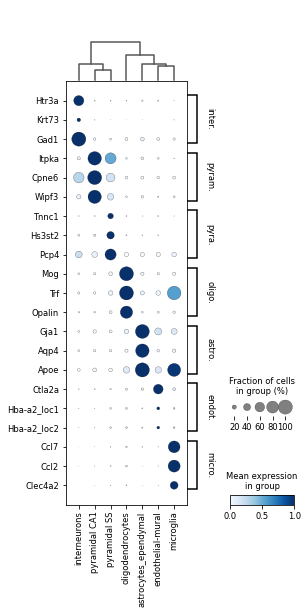

In [18]:
sc.pl.dotplot(
    adata,
    markers,
    groupby='cell_type',
    dendrogram=True,
    color_map="Blues",
    swap_axes=True,
    use_raw=True,
    standard_scale="var",
)

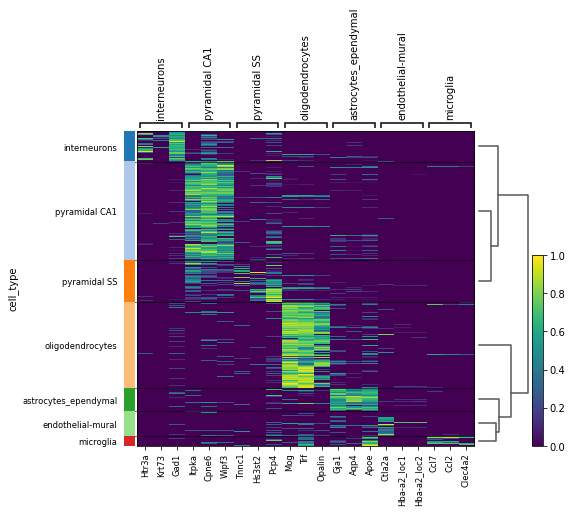

In [19]:
sc.pl.heatmap(
    adata,
    markers,
    groupby='cell_type',
    standard_scale="var",
    dendrogram=True,
)

## Beyond the basics

In [24]:
# dowstream expects raw data, reload the raw counts we had
adata.X = adata.layers["counts"].copy()

In [25]:
###  SELECT GENES AND PREPARE DATA
scvi.data.poisson_gene_selection(adata,
                                 #batch_key='batch', # estimate a dispersion parameter batchwise
                                 n_top_genes = 1000, # how many genes to select
                                 n_samples=30000
                                 )

/Users/ksenia/Documents/!Summer2019/DeepSea_Disease/deepsea-disease/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Sampling from binomial...: 100%|██████████| 30000/30000 [00:07<00:00, 4225.78it/s]


In [26]:
adata.var.head()

,n_counts,highly_variable,highly_variable_rank,means,variances,variances_norm,observed_fraction_zeros,expected_fraction_zeros,prob_zero_enriched_nbatches,prob_zero_enrichment,prob_zero_enrichment_rank
Tshz1,1273.0,True,1549.0,0.423627,1.478603,1.687389,0.809318,0.676300,1,0.259100,1321.0
2310042E22Rik,316.0,False,667.0,0.105158,0.466302,2.365589,0.962063,0.902278,0,0.095000,830.0
Sema3c,3197.0,True,66.0,1.063894,24.304172,7.650647,0.807987,0.407975,1,0.481800,1894.0
Jam2,822.0,True,924.0,0.273544,1.108238,2.076384,0.860899,0.771742,1,0.198667,1149.0
Klhl13,1892.0,True,766.0,0.629617,3.196659,2.233131,0.756073,0.569527,1,0.325433,1485.0


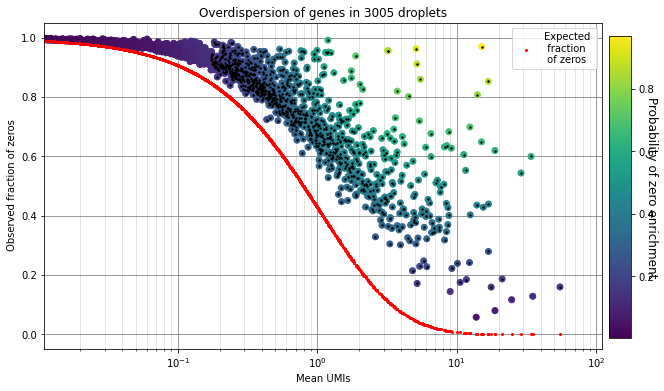

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))

subtitle = f'Overdispersion of genes in {len(adata.obs)} droplets'
df = adata.var
df['mean'] = np.array(adata.X.mean(0))#[0]
x=df['mean'],
y=df['observed_fraction_zeros']
yred=df['expected_fraction_zeros']
color=df['prob_zero_enrichment']
ax.grid(b=True, which='major', color='gray', linestyle='-')
ax.grid(b=True, which='minor', color='gainsboro', linestyle='-')
ax.set_axisbelow(True)
ax.scatter(x, y, c=color, cmap='viridis')
selx = df.query('highly_variable')['mean']
sely = df.query('highly_variable')['observed_fraction_zeros']
ax.scatter(selx, sely, c='k', s = 2)

leg = ax.scatter(x, yred, c='red', s = 4, label='Expected fraction of zeros')

ax.set_xscale('log')

ax.set_title(subtitle)
ax.label_outer()
ax.set_xlim(0.011, 110)
ax.set_ylim(-0.05, 1.05)


plt.subplots_adjust(wspace=0, hspace=0)
plt.xlabel('Mean UMIs')
plt.ylabel(' Observed fraction of zeros')

plt.legend([leg],['Expected \n fraction \n of zeros'])
im = plt.gca().get_children()[0]
cax = fig.add_axes([0.91,0.15,0.03,0.7])

cbar = fig.colorbar(im, cax)
cbar.set_label('Probability of zero enrichment',rotation=270, fontsize = 12)